# Molecular optimization with hierarchical coarse-grained models

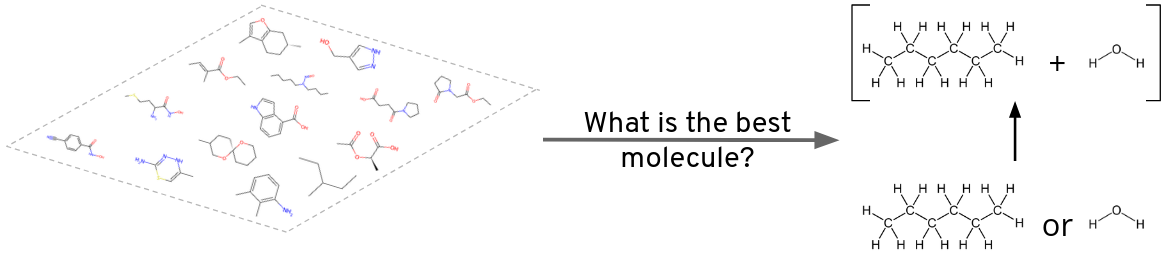

In this tutorial, we will perform a simple molecular optimization using hierarchical coarse-graining with Bayesian optimization. The goal is to efficiently identify a small molecule that shows a strong preference for residing in an hexane-water mixture rather than in pure water or pure hexane. This preference can be quantified using a free energy difference, known as the **transfer free energy**. Thus, our optimization target is to maximize this transfer free energy.

While this oil-water target system is relatively simple and basic chemical intuition might suggest what kind of molecules we expect from the optimization, the same methodology can be applied to more complex systems where no prior knowledge about relevant molecular candidates is available. To keep the tutorial accessible, we introduce further simplifications, such as limiting the size of the small molecules to 10 heavy atoms. Nonetheless, the procedure presented here illustrates the general principles behind the optimization strategy.

The tutorial is based on the arXiv paper [Navigating Chemical Space: Multi-Level Bayesian Optimization with Hierarchical Coarse-Graining](https://doi.org/10.48550/arXiv.2505.04169).

### **Overview**
The following list outlines the structure of the tutorial. Parts 4 and 5 contain a machine learning component, while Parts 1 through 3 introduce preliminaries related to coarse-graining and molecular dynamics simulations.
1. Coarse-graining approach *(2 min)*
2. Simulations of the target system *(5 min)*
3. Molecule enumeration *(5 min)*
4. Latent-space encoding *(10 min)*
5. Molecular optimization *(13 min)*
6. Derivation of design rules (remaining time)


The following code imports all required libraries and checks the version of the molecular dynamics simulation program [GROMACS](https://www.gromacs.org/):

In [ ]:
# Imports python packages and checks GROMACS version
import warnings
from pathlib import Path
from subprocess import run
from itertools import combinations_with_replacement
import numpy as np
import pandas as pd

""" Load libraries for visualizations """
import matplotlib.pyplot as plt
import seaborn as sns
import MDAnalysis as mda
import nglview as nv

""" Load machine learning libraries """
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.nn.functional import one_hot, cross_entropy, softmax
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

""" Load and silence alchemlyb library for MBAR free energy calculations """
import logging
logging.getLogger("pymbar").setLevel(logging.ERROR)
from alchemlyb.estimators import MBAR
from alchemlyb.parsing.gmx import extract_u_nk

""" Check GROMACS version and GPU support """
!gmx -version | grep -Ei '(gpu support|gromacs version)'

## <ins>Coarse-graining approach</ins>

Although typically used to speed up simulations, we want to use coarse-graining to reduce the complexity of chemical space. There are various methods for obtaining coarse-grained (CG) representations of molecules. Here, the coarse-graining is based on the so-called [Martini3](https://doi.org/10.1038/s41592-021-01098-3) model. The following image illustrates the coarse-graining for the molecule [Lutein](https://en.wikipedia.org/wiki/Lutein) ([Source](https://doi.org/10.3390/ijms25147947)):

<div style="text-align: center;">
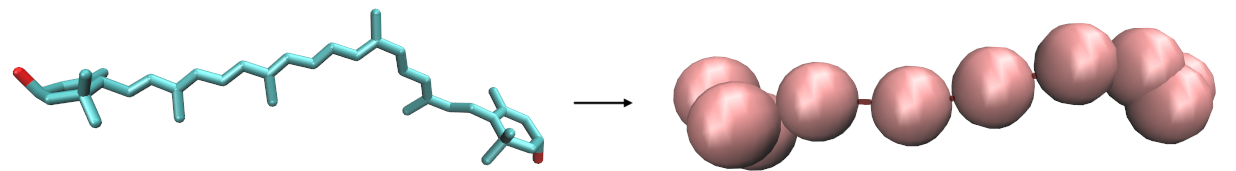
</div>

The interactions between the CG beads are determined by their bead types, which are assigned based on the underlying chemical fragments. [Martini3](https://doi.org/10.1038/s41592-021-01098-3) employs a **fixed set of bead types** that can be reused across a wide range of molecules, making it a **transferable CG force field**.

Coarse-graining inherently reduces molecular detail, allowing multiple atomistic structures to be mapped to the same CG representation. We exploit this **many-to-one relationship** to reduce the complexity of the chemical search space.

For simplicity, we will focus on molecules consisting of only two coarse-grained beads.

## <ins>Simulations of the target system</ins>

We begin by examining our target system: a mixture of hexane and water, two solvents that differ significantly in polarity. In our coarse-grained (CG) model, water is represented by a single bead, while hexane is modeled using two beads. As an initial step, we run a short simulation using the MD software [GROMACS](https://www.gromacs.org):

<div style="background-color:powderblue;">
<details>

<summary>Toggle to see an explanation of the following simulation commands</summary>

* `gmx grompp` is the command to prepare a GROMACS simulation (see [here](https://manual.gromacs.org/current/onlinehelp/gmx-grompp.html) for further details)
* `-f mixture.mdp` provides a file with all the simulation parameters, e.g., temperature, number of integration steps, ... (see [here](https://manual.gromacs.org/current/user-guide/mdp-options.html) for further details)
* `-c mixture.gro` provides a file with the initial structure
* `-p mixture.top` provides a topology file that describes bonded and non-bonded interactions between atoms or CG beads
* `-o mixture/simulation.tpr` path for the output of the simulation file
* `gmx mdrun -deffnm mixture/simulation` runs the simulation for the provided simulation filename (see [here](https://manual.gromacs.org/current/onlinehelp/gmx-mdrun.html) for further information)
* `> mixture/simulation.run.log 2>&1` saves the output to the specified file

Feel free to check the contents of the individual files if you are interested!
</details>
</div>

In [ ]:
!mkdir -p mixture
!gmx grompp -f mixture.mdp -c mixture.gro -p mixture.top -o mixture/simulation.tpr > mixture/simulation.run.log 2>&1
!gmx mdrun -deffnm mixture/simulation >> mixture/simulation.run.log 2>&1

We redirect the simulation output to the file `mixture/simulation.run.log`. If the simulation was successfull, it should contain a table with information about the simulation performance:

In [ ]:
!tail -n 7 mixture/simulation.run.log

Let's now visualize the simulation:

In [ ]:
# Fix periodic boundaries in the trajectory file
!echo -e "0\n" | gmx trjconv -f mixture/simulation.xtc -s mixture/simulation.tpr -o mixture/simulation-no-pbc.xtc -pbc mol >> mixture/simulation.run.log 2>&1
# Load simulation trajectory with fixed periodic boundaries
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    u = mda.Universe("mixture/simulation.tpr", "mixture/simulation-no-pbc.xtc")
# Visualize trajectory
view = nv.show_mdanalysis(u)
view.add_representation('spacefill', selection=':HEX', color='gray', radius=0.5) # hexane
view.add_representation('spacefill', selection=':W', color='lightblue', radius=0.5) # water
view

Initially, the hexane and water are completely mixed. Over the course of the simulation, you should observe the two solvents separating.

In the following optimization, we want to discover a molecule with a strong preference for the hexane-water mixture in comparison to pure hexane or pure water. As mentioned above, we use the transfer free energies to quantify this preference. The transfer free energies can be calculated from multiple MD simulations.

To calculate the transfer free energies between the pure solvents and the mixture, we first calculate **solvation free energies** for the three individual systems: $\Delta G_{\text{Hexane}}$, $\Delta G_{\text{Water}}$, $\Delta G_{\text{Mixture}}$. Since the free energy is a state variable, we can use a thermodynamic cycle and the solvation free energies to obtain transfer free energies:
$$
\Delta\Delta G_{\text{Hexane}\rightarrow\text{Mixture}} = \Delta G_{\text{Mixture}} - \Delta G_{\text{Hexane}}
$$
$$
\Delta\Delta G_{\text{Water}\rightarrow\text{Mixture}} = \Delta G_{\text{Mixture}} - \Delta G_{\text{Water}}
$$
The sign of such free energy differences is arbitrary. Here, we define the difference such that a positive sign indicates a preference for the mixture. Since we want to maximize the preference for the mixture in comparison to both pure solvents we combine both transfer free energies using a min-function. The final optimization objective becomes:
$$
\Delta\Delta G = \min(\Delta\Delta G_{\text{Hexane}\rightarrow\text{Mixture}}, \Delta\Delta G_{\text{Water}\rightarrow\text{Mixture}})
$$

To actually calculate these free-energy values, we use a method called thermodynamic integration (TI). The details are beyond the scope of this tutorial (see [Wikipedia](https://en.wikipedia.org/wiki/Thermodynamic_integration) or [this paper](https://doi.org/10.33011/livecoms.2.1.18378) if you are interested) but each TI calculation requires multiple simulations. The more simulations we use, the more accurate the obtained free energies. Therefore, we need to balance required accuracy with compute time.

The code in the collapsed cell below defines the functions `run_molecule_simulations` and `calculate_free_energy_difference`. The details are not relevant for this tutorial but if you are interested you can check it out.

In [ ]:
def run_molecule_simulations(molecule: str, delete_on_failure: bool = False):
  """
  Run TI simulations for a two-bead molecule in water, hexane, and a mixture.
  Since minimized structure files are provided, the energy minimization step is skipped.
  :param molecule: A string representing the two bead molecule in the format 'A-B'.
  :param delete_on_failure: Delete simulation directory for system if simulation fails.
  """
  try:
    molecule_path = Path('simulations') / molecule
    for system in ['water', 'hexane', 'mixture']:
      """ Directory setup """
      system_path = molecule_path / system
      if system_path.exists():
        continue
      system_path.mkdir(parents=True, exist_ok=True)
      """ Setup the system for each environment """
      topology = Path(f'{system}-lig.top').read_text()
      for placeholder, replacement in zip(['B1', 'B2'], molecule.split('-')):
        topology = topology.replace(placeholder, replacement)
      Path(system_path / 'system.top').write_text(topology)
      """ Perform system equilibration """
      command = (f'gmx grompp -f equilibration.mdp -c {system}-lig.gro -p {system_path}/system.top ' +
          f'-o {system_path}/equilibration.tpr -po {system_path}/equilibration.out.mdp ' +
          f'>> {system_path}/simulation.run.log 2>&1 && gmx mdrun -deffnm {system_path}/equilibration  -ntmpi 1 ' +
          f'>> {system_path}/simulation.run.log 2>&1')
      print(f'Running simulation 1/9 for the {system} environment', end='\r')
      run(command, shell=True, check=True)
      """ Adjust the number of integration steps depending on the environment. """
      command = 'sed -i "s/^nsteps.*/nsteps                   = {nsteps}/" lambda-run.mdp'
      if system == 'mixture':
        run(command.format(nsteps=30000), shell=True, check=True)
      else:
        run(command.format(nsteps=20000), shell=True, check=True)
      """ Run eight lambda-step simulations """
      for i in range(8):
        lambda_path = system_path / f'lambda{i}'
        lambda_path.mkdir(exist_ok=True)
        command = f'sed -i "s/^init-lambda-state.*/init-lambda-state        = {i}/" lambda-run.mdp'
        run(command, shell=True, check=True)
        command = (f'gmx grompp -f lambda-run.mdp -c {system_path}/equilibration.gro -p {system_path}/system.top ' +
          f'-o {lambda_path}/production.tpr -po {lambda_path}/production.out.mdp ' +
          f'>> {lambda_path}/simulation.run.log 2>&1 && gmx mdrun -deffnm {lambda_path}/production -ntmpi 1 ' + 
          f'>> {lambda_path}/simulation.run.log 2>&1')
        print(f'Running simulation {i+2}/9 for the {system} environment', end='\r')
        run(command, shell=True, check=True)
  except Exception as e:
    if delete_on_failure:
        run(f'rm -r {system_path}', shell=True, check=True)
    print(f'Failed to simulate {molecule}, please retry')
    raise e

def calculate_free_energy(molecule: str, system: str) -> tuple[float, float]:
    """
    Calculate solvation free energies for a given molecule and system using the
    MBAR algorithm (https://doi.org/10.1063/1.2978177). This function assumes
    completed simulations.
    :param molecule: A string representing the two bead molecule in the format 'A-B'.
    :param system: One of the three systems: 'water', 'hexane', 'mixture'
    :returns: The solvation free energy and an uncertainty estimate in kcal/mol.
    """
    """ Collection data from simulation output files """
    path = Path('simulations') / molecule / system
    if not path.exists():
        raise ValueError(f"Simulations for {molecule}/{system} not found")
    xvg_files = [p / 'production.xvg' for p in path.iterdir() if p.is_dir()]
    u_nk_list = [extract_u_nk(f, T=305) for f in xvg_files]
    u_nk_combined = pd.concat(u_nk_list)
    """ Perform MBAR calculation """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        mbar = MBAR().fit(u_nk_combined)
    """ Extract result and convert unit """
    free_energy = float(mbar.delta_f_.iloc[0, -1]) * 0.5924  # Convert to kcal/mol
    d_free_energy = float(mbar.d_delta_f_.iloc[0, -1]) * 0.5924 # Convert to kcal/mol
    return free_energy, d_free_energy

def calculate_free_energy_difference(molecule: str, print_system_result: bool = False) -> float:
  """
  Calculate the min between the transfer free energy from hexane to the mixture
  and water to the mixture.
  :param molecule: A string representing the two-bead molecule in the format 'A-B'.
  :param print_system_results: Print solvation free energies for the individual systems.
  :return: min(ddG_Mixture - ddG_Hexane, ddG_Mixture - ddG_Water)
  """
  result = {}
  for system in ['water', 'hexane', 'mixture']:
    ddg, ddg_err = calculate_free_energy(molecule, system)
    result[system] = ddg
    if print_system_result:
        print(f'dG_{system} = {ddg:.2f} ± {ddg_err:.2f} kcal/mol')
  return min(result['mixture'] - result['hexane'], result['mixture'] - result['water'])

Let's evaluate the transfer free energy for an example molecule with the two CG beads called `K3` and `K4`. The simulations will take at least one minute.

In [ ]:
run_molecule_simulations('K3-K4')

After running the simulations, we can calculate the transfer free energy $\Delta\Delta G$:

In [ ]:
ddG = calculate_free_energy_difference('K3-K4', print_system_result=True)
print(f'ddG = {ddG:.3f} kcal/mol')

The $\Delta\Delta G$ result is (or should be) negative. This indicates a preference for one of the pure environments. In this case, $\Delta G_{\text{Hexane}} > \Delta G_{\text{Water}}$, which means a preference for hexane.

## <ins>Molecule enumeration</ins>
To identify the optimal molecule for a target property, we bypass atomistic structures and directly enumerate the relevant chemical space at the CG level. This significantly reduces combinatorial complexity, yielding fewer candidate molecules and a more manageable search space—though at the cost of chemical detail.

Choosing a CG resolution involves a trade-off: higher resolutions with more bead types capture atomistic detail more accurately but increase the chemical space's complexity; lower resolutions simplify the search but lose detail.

**Hierarchical coarse-graining**: To balance detail and simplicity, we use two CG resolutions in a funnel-like optimization. Here, the high-resolution model uses 22 bead types, while the low-resolution model uses just 4. The image below illustrates the relationship between these resolutions. The properties of the bead types are not important here. We just note, that high-resolution bead types with the same first character (P, N, C, or X) have similar properties, which allows us to combine them into a single bead type at the low resolution.

<div style="text-align: center;">
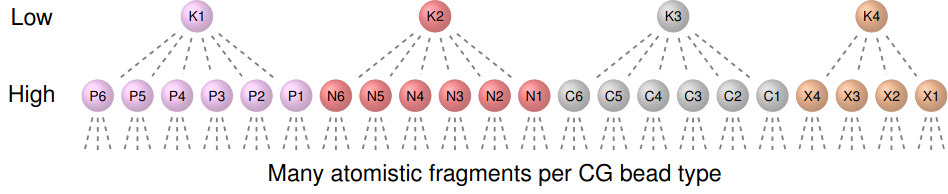
</div>

We will focus on the two CG levels here and will come back to the atomistic resolution at the end of the tutorial.

Let's now enumerate all unique CG molecules with two beads for both resolution levels:

In [ ]:
low_res_bead_types = [
    'K1', 'K2', 'K3', 'K4'
]
high_res_bead_types = [
    'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6',
    'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'X1', 'X2', 'X3', 'X4'
]
low_res_molecules = ['-'.join(sorted(beads)) for beads in combinations_with_replacement(low_res_bead_types, 2)]
high_res_molecules = ['-'.join(sorted(beads)) for beads in combinations_with_replacement(high_res_bead_types, 2)]
print(f"Number of low resolution molecules: {len(low_res_molecules)}")
print(f"Number of high resolution molecules: {len(high_res_molecules)}")

From the known mapping between bead types, we can construct a mapping between the molecules at different resolutions:

In [ ]:
bead_mapping = {'X': 'K4', 'C': 'K3', 'N': 'K2', 'P': 'K1'}
def map_bead_types(mol):
    new_beads = [bead_mapping[bead[0]] for bead in mol.split('-')]
    return '-'.join(sorted(new_beads))

mapping = {mol: map_bead_types(mol) for mol in high_res_molecules}
print(f"Example mapping: {high_res_molecules[0]} -> {mapping[high_res_molecules[0]]}")

The idea for the optimization is to use the low-resolution model (with only 10 molecules) to roughly estimate the transfer free energies of the high-resolution molecules. This reduces the total number of molecule evaluations required.

Typically, we would run simulations and calculate the transfer free energies of all low-resolution molecules at this stage. However, to speed things up, we provide the following dictionary with precomputed $\Delta\Delta G$ values:

In [ ]:
low_res_ddG_results = {
    'K1-K1': -1.321, 'K3-K3': -1.025, 'K4-K4': -0.740, 'K3-K4': -0.606, 'K1-K2': -0.056,
    'K2-K3':  0.163, 'K2-K2':  0.601, 'K2-K4':  0.665, 'K1-K4':  0.871, 'K1-K3':  0.983,
}
print(f"ddG_(K3-K4) = {low_res_ddG_results['K3-K4']} kcal/mol")

You can compare the result from the dictionary with your simulation result for `K3-K4` from above.

## <ins>Encode molecules</ins>
In this section, we will perform a numerical encoding of the discrete set of molecules using a [regularized autoencoder neural network](https://doi.org/10.48550/arXiv.1903.12436).

**Why do we need a numerical encoding?** Even if we have a low resolution *prior* for all high resolution molecules, we still don't want to evaluate all likely interesting candidates to find the optimal molecule. This kind of exhaustive evaluation would be possible for our simple example, but is not feasible for larger systems and molecules. To explore the space of molecules more efficiently, we use **Bayesian optimization**. More details about Bayesian optimization follow in one of the other tutorials. Bayesian optimization provides an intuitive way to integrate the low-resolution information into the optimization of high-resolution CG molecules. However, to perform Bayesian optimization we need a **correlation or similarity measure between molecules**. To obtain such a measure, we perform a numerical encoding of the molecules and use distances in the encoding space to measure similarity between molecules.

<div style="text-align: center;">
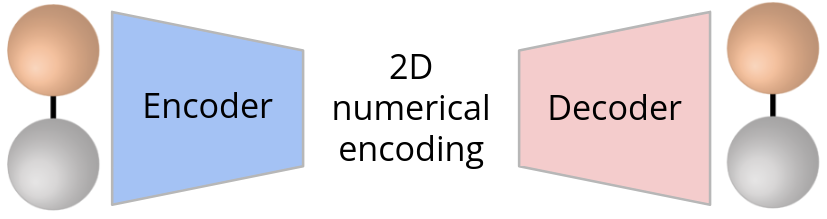
</div>

For larger molecular structures, a graph neural network could be used to encode the molecules. However, since we work with simple two-bead molecules, we use basic [MLPs](https://en.wikipedia.org/wiki/Multilayer_perceptron) instead. Various bead featurizations are possible, and the more information included, the more meaningful the resulting numerical representation. The simplest option, requiring no prior knowledge, is one-hot encoding: with 22 bead types, each bead is represented by a 22-dimensional vector. If additional information about bead relationships is available, it can be incorporated into the encoding. In our case, we assume that bead types sharing the same letter have similar properties, so we use separate one-hot encodings for the letter and digit components of the bead names:

In [ ]:
def one_hot_representation(mol: str) -> torch.Tensor:
    """
    One-hot encoding of a two-bead molecule.
    The resulting 20-entry vector has the following structure:
      - 6 bits for the index of the first bead
      - 4 bits for the letter of the first bead
      - 6 bits for the index of the second bead
      - 4 bits for the letter of the second bead
    :param mol: String representation of the molecule ("A-B")
    """
    indices = [int(b[1])-1 for b in mol.split('-')]
    types = [['P', 'N', 'C', 'X'].index(b[0]) for b in mol.split('-')]
    indices_one_hot = one_hot(torch.LongTensor(indices), 6)
    types_one_hot = one_hot(torch.LongTensor(types), 4)
    return torch.cat((indices_one_hot,types_one_hot), dim=1).flatten().float()

Let's check the one-hot encoded representation of the molecule `C1-P1`:

In [ ]:
one_hot_representation('C1-P1')

Next, we define the autoencoder model:

In [ ]:
class Autoencoder(nn.Module):

  def __init__(self):
    super(Autoencoder, self).__init__()
    """ Embedding of the bead types """
    self.embedding = nn.Sequential(
      nn.Linear(10,32), nn.ReLU(True),
      nn.Linear(32,16)
    )
    """ Encodes the concatenated bead type embeddings """
    self.encoder = nn.Sequential(
      nn.Linear(32,128), nn.ReLU(True),
      nn.Linear(128,2)
    )
    """ Decode the one-hot encoded molecule input """
    self.decoder = nn.Sequential(
      nn.Linear(2,128), nn.ReLU(True),
      nn.Linear(128,128), nn.ReLU(True),
      nn.Linear(128,20)
    )

  def encode(self, x: torch.Tensor) -> torch.Tensor:
    embedding1 = self.embedding(x[:,:10])
    embedding2 = self.embedding(x[:,10:])
    x = torch.cat((embedding1, embedding2), dim=1)
    return self.encoder(x)

  def decode(self, x: torch.Tensor) -> torch.Tensor:
    return self.decoder(x)

Because molecules are permutation invariant, we need a permutation-invariant loss function. While constructing such a loss is challenging for larger molecules, it is straightforward for two-bead molecules, which have only two possible permutations. We can simply evaluate both and choose the smaller loss.

#### **Task: Implement a permutation invariant loss:**
Using the [`cross_entropy`](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html) function, implement a permutation invariant loss for the molecule reconstruction:

In [ ]:
def invariant_reconstruction_loss(decoded: torch.Tensor, target: torch.Tensor):
    decoded_index1, decoded_class1 = decoded[:,:6], decoded[:,6:10]
    decoded_index2, decoded_class2 = decoded[:,10:16], decoded[:,16:]
    input_index1, input_class1 = target[:,:6], target[:,6:10]
    input_index2, input_class2 = target[:,10:16], target[:,16:]
    # TODO
    # Use: cross_entropy(decoded, target, reduction='none')
    return #TODO

The collapsed code block below shows how the implementation could look like:

In [ ]:
def invariant_reconstruction_loss(decoded: torch.Tensor, target: torch.Tensor):
    decoded_index1, decoded_class1 = decoded[:,:6], decoded[:,6:10]
    decoded_index2, decoded_class2 = decoded[:,10:16], decoded[:,16:]
    input_index1, input_class1 = target[:,:6], target[:,6:10]
    input_index2, input_class2 = target[:,10:16], target[:,16:]
    loss1 = (cross_entropy(decoded_index1, input_index1, reduction='none') +
             cross_entropy(decoded_class1, input_class1, reduction='none') +
            cross_entropy(decoded_index2, input_index2, reduction='none') +
             cross_entropy(decoded_class2, input_class2, reduction='none'))
    loss2 = (cross_entropy(decoded_index1, input_index2, reduction='none') +
             cross_entropy(decoded_class1, input_class2, reduction='none') +
            cross_entropy(decoded_index2, input_index1, reduction='none') +
             cross_entropy(decoded_class2, input_class1, reduction='none'))
    return torch.minimum(loss1, loss2).mean()

With this setup we can run the optimization of our autoencoder model:

In [ ]:
""" Featurize all molecules """
mol_features = torch.stack([one_hot_representation(m) for m in high_res_molecules])
""" Initialize autoencoder model """
model = Autoencoder()
""" Setup ADAM optimizer with decoder regularization """
optimizer = torch.optim.Adam([
    {'params': model.embedding.parameters()},
    {'params': model.encoder.parameters()},
    {'params': model.decoder.parameters(), 'weight_decay': 1e-3}
  ], lr=0.001)

In [ ]:
for epoch in range(2500):
    optimizer.zero_grad()
    encoded = model.encode(mol_features)
    decoded = model.decode(encoded)
    latent_loss = 0.5 * torch.mean(encoded**2) # Latent space regularization
    recon_loss = invariant_reconstruction_loss(decoded, mol_features)
    loss = recon_loss + 0.08 * latent_loss
    loss.backward()
    optimizer.step()
print(f"Epoch {epoch+1}: Loss = {recon_loss.item():.4f}, Latent Loss = {latent_loss.item():.4f}")

To reconstruct molecules from the autoencoder prediction, we use the following function:

In [ ]:
def molcule_from_autoencoder_prediction(prediction: torch.Tensor) -> str:
    """
    Reconstruct a two-bead molecule from the decoder prediction.
    :param prediction: 20-entry decoder prediction vector
    :return: String representation of the reconstructed molecule
    """
    decoded_index1, decoded_class1 = prediction[:6], prediction[6:10]
    decoded_index2, decoded_class2 = prediction[10:16], prediction[16:]
    i1 = softmax(decoded_index1, dim=0).argmax() + 1
    c1 = ['P', 'N', 'C', 'X'][softmax(decoded_class1, dim=0).argmax()]
    i2 = softmax(decoded_index2, dim=0).argmax() + 1
    c2 = ['P', 'N', 'C', 'X'][softmax(decoded_class2, dim=0).argmax()]
    return '-'.join(sorted([f'{c1}{i1}', f'{c2}{i2}']))

Now we analyze the 2d encoding of our molecules. You should get a reconstruction accuracy of over 95%.

In [ ]:
""" Encode and decode all molecules """
encoded = model.encode(mol_features)
decoded = model.decode(encoded)
encoded = encoded.detach().numpy()
""" Iterate over all molecules and check reconstruction """
correct_reconstructions = 0
for n in range(len(high_res_molecules)):
  recon = molcule_from_autoencoder_prediction(decoded[n])
  correct_reconstructions += int(recon == high_res_molecules[n])
  if n % 50 == 0:
    """ Print every 50th molecule reconstruction and target"""
    print(f'Target: {high_res_molecules[n]} Reconstructed: {recon}, Latent space: {encoded[n]}')
""" Print reconstruction accuracy """
print(f'\nReconstruction accuracy: {correct_reconstructions / len(high_res_molecules):.3f}')
""" Visualize molecular encoding space """
g = sns.JointGrid(x=encoded[:, 0], y=encoded[:, 1], height=6, ratio=11)
g.plot_joint(sns.scatterplot, color='red', s=15)
g.plot_marginals(sns.kdeplot, fill=True, color='gray')
for n in range(len(high_res_molecules)):
    g.ax_joint.annotate(str(high_res_molecules[n]), (encoded[n, 0], encoded[n, 1]), fontsize=6)
g.ax_joint.set_xlabel("Encoding dimension 1")
g.ax_joint.set_ylabel("Encoding dimension 2")
g.ax_joint.margins(-0.05)
g.fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95, hspace=0.0, wspace=0.0)
plt.show()


**Have a look at the encoded molecule space**
1. What encoding space structure do you observe and why do we have this structure?
2. If you are familar with autoencoders: Why do we get a Gaussian-like distribution of the latent space without using a variational autoencoder?

## <ins>Molecular optimization</ins>

We’re now ready to perform molecular optimization. Recall that our goal is to identify the optimal high-resolution CG molecule for the hexane–water system, using simulation results from low-resolution CG molecules as a prior.

To do this, we apply **Bayesian optimization (BO)**—a method designed for optimizing functions where gradients are unavailable or expensive to compute. Since each function evaluation requires a simulation, we aim to find the optimum with as few evaluations as possible—much fewer than what would be needed with random sampling or grid search.

BO works by building a surrogate model that predicts both the **value and uncertainty** of the function across the input space. From this, we compute an **acquisition function** that guides the search by balancing **exploration** (uncertain regions) and **exploitation** (promising regions). Maximizing the acquisition function tells us which molecule to evaluate next.

To integrate the information from the low-resolution model, we use a delta-learning approach:
$$
\Delta\Delta G_{\text{high res.}}(x) = \Delta\Delta G_{\text{low res.}}\big(\mathcal{M}(x)\big) + \delta(x)
$$
with the high resolution molecule $x$ and the mapping function $\mathcal{M}(x)$.

First, we setup the acquisition function:

In [ ]:
def acquisition_function(values: torch.Tensor, uncertainty: torch.Tensor, best_known_value: float, xi: float = 0.0):
  z = (values - best_known_value - xi)
  return z * norm.cdf(z / uncertainty) + uncertainty * norm.pdf(z / uncertainty)

Next, we intialize a dictionary for the transfer free energy results:

In [ ]:
simulation_data = {}
low_resolution_prior = np.array([low_res_ddG_results[mapping[mol]] for mol in high_res_molecules])

Now we run $n=10$ Bayesian optimization steps. For the surrogate model, we use a [Gaussian Process](https://peterroelants.github.io/posts/gaussian-process-tutorial/) with an RBF kernel. To implement the delta-learning approach mentioned above, we first substract the low-resolution value (line 11), fit the model to the resulting differences (line 14), and later add the low-resolution prior to the result (line 18).

In [ ]:
for i in range(10):
  """ Setup Gaussian process with the RBF kernel """
  kernel = RBF(length_scale=0.5, length_scale_bounds=(0.05, 2))
  gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=0.05)
  """ Fit Gaussian process with evaluated high-resolution data """
  current_best = max(low_res_ddG_results.values())
  if len(simulation_data) > 0:
    current_best = max(simulation_data.values())
    X = [encoded[i] for i, m in enumerate(simulation_data)]
    # Substract low-resolution prior
    Y = [result - low_res_prior[i] for i, result in simulation_data.items()]
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      gaussian_process.fit(X, Y)
  """ Predict values and uncertainties for all molecules """
  prediction_input = [encoded[i] for i, m in enumerate(high_res_molecules)]
  mean_prediction, std_prediction = gaussian_process.predict(prediction_input, return_std=True)
  mean_prediction = mean_prediction + low_res_prior # Readd low resolution prior
  """ Calculate and maximize the acquisition function for unknown molecules """
  af = acquisition_function(mean_prediction, std_prediction, current_best)
  af = np.ma.masked_array(ei, mask=np.isin(np.arange(len(af)), list(simulation_data.keys())))
  next_index = np.random.choice(np.nonzero(af == af.max())[0])
  next_molecule = high_res_molecules[next_index]
  """ Evaluate next molecule """
  print(f'Simulating next molecule: {next_molecule}')
  run_molecule_simulations(next_molecule)
  simulation_result = calculate_free_energy_difference(next_molecule)
  print(f'\nSimulation result: {simulation_result:.3f}')
  simulation_data[next_index] = simulation_result

Although 10 evaluations might not be enough to find the best molecule from the full analyzed chemical space, we were able to find molecules with large $\Delta\Delta G$ values by performing only 20 free-energy evaluations (including the 10 low-resolution evaluations).

Let's check to top three obtained molecules and their transfer free energy result:

In [ ]:
for i, res in sorted(simulation_data.items(), key=lambda x: x[1])[-3:]:
  print(f'{high_res_molecules[i]}: {res:.3f}')